In [1]:
# Read in data
import pandas as pd
import seaborn as sns
import pyspark.sql.functions as F
import re
sns.set_theme()
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'
filenames = ['VM2Uniform--CA--2021-05-02',
             'VM2Uniform--AZ--2021-05-20',
             'VM2Uniform--MA--2021-01-19',
             'VM2Uniform--ND--2021-03-18']
states = ['CA', 'AZ', 'MA', 'ND']

# We will analyze how these demographic variables are associated with turnout
columns_of_interest = ['State', 'LALVOTERID', 'County', 'CommercialData_Education', 'CommercialData_EstimatedHHIncome',
                       'CommercialData_EstHomeValue', 'Voters_Gender', 'Voters_Age', 'Parties_Description', 
                       'EthnicGroups_EthnicGroup1Desc',
                       'ElectionReturns_G08CountyTurnoutAllRegisteredVoters',
                       'ElectionReturns_G10CountyTurnoutAllRegisteredVoters',
                       'ElectionReturns_G12CountyTurnoutAllRegisteredVoters',
                       'ElectionReturns_G14CountyTurnoutAllRegisteredVoters',
                       'ElectionReturns_G16CountyTurnoutAllRegisteredVoters',
                       'ElectionReturns_G18CountyTurnoutAllRegisteredVoters']

dfs = []
for file, state in zip(filenames, states):
    temp_df = spark.read.parquet("/".join([gcs_path, file]))
    temp_df = temp_df.withColumn('State', F.lit(state))
    temp_df = temp_df.select(columns_of_interest)
    dfs.append(temp_df)

In [2]:
df = dfs[0]
for i in range(1, 4):
    df = df.union(dfs[i])

#ca_df = ca_raw_df.select(columns_of_interest)

In [3]:
#df.show(5, vertical=True)

In [4]:
#df.printSchema()

Here we will clean the data in the Dataframe and additionally rename some columns. 
There are a few issues we can fix that will make the data easier to read and work with.

In [5]:
import pyspark.sql.functions as F

# Voters_Age is a string but should be an int
# We rename to just "age" as well
df_clean = df.withColumn('Voters_Age', F.col('Voters_Age').cast('integer'))\
    .withColumnRenamed('Voters_Age', 'Age')

# This column has a '$' in it but we would like it to be numeric
df_clean = df_clean.withColumn('Estimated_Home_Value',
                               F.regexp_replace('CommercialData_EstHomeValue', r'\$', '').cast('integer'))\
                    .drop('CommercialData_EstHomeValue')

# Education column contains both estimated education and accuracy.
# We split into two columns here
df_clean = df_clean.withColumn('Education', F.trim(F.split('CommercialData_Education', '-')[0]))\
    .withColumn('Education_Likelihood', F.trim(F.split('CommercialData_Education', '-')[1]))\
    .drop('CommercialData_Education')

# Election cols have a '%' in them but we would like them to be numeric
# We rename too, since the names are very large
# Additionally, we remove the "CommercialData" prefix from a few columns
for c in columns_of_interest:
    if 'Election' in c:
        df_clean = df_clean.withColumn(c, F.regexp_replace(c, r'%', '').cast('integer'))
        year = "20" + c.split('_G')[1][0:2]
        df_clean = df_clean.withColumnRenamed(c, year + "_Turnout")

# Rename the rest of the columns
df_clean = df_clean.withColumnRenamed('Voters_Gender', 'Gender')\
    .withColumnRenamed('Parties_Description', 'Party')\
    .withColumnRenamed('EthnicGroups_EthnicGroup1Desc', 'Ethnic_Group')\
    .withColumnRenamed('CommercialData_EstimatedHHIncome', 'Estimated_Household_Income')

In [ ]:
#df_clean.printSchema()

In [7]:
#df_clean.show(5, vertical=True)

In [8]:
#df_clean.groupBy('Education').count().show(truncate=False)

In [9]:
turnout_cols = [col for col in df_clean.columns if "Turnout" in col]

In [10]:
#df_clean.select(['State','County'] + turnout_cols).groupby('State', 'County').avg().show()

# EDA Graphs

In [11]:
turnout_df = df_clean.select(['State', 'County'] + turnout_cols).groupby('State', 'County').avg().toPandas()

In [12]:
cols_to_unpivot = [col for col in turnout_df.columns if col not in ['State', 'County']]

In [13]:
turnout_df_unpivoted = turnout_df.melt(id_vars=['State', 'County'], value_vars = cols_to_unpivot, value_name='Turnout')
turnout_df_unpivoted["Year"] = turnout_df_unpivoted['variable'].str.extract(r"(\d+)")
turnout_df_unpivoted = turnout_df_unpivoted.drop('variable', axis=1)

In [14]:
#turnout_df_unpivoted

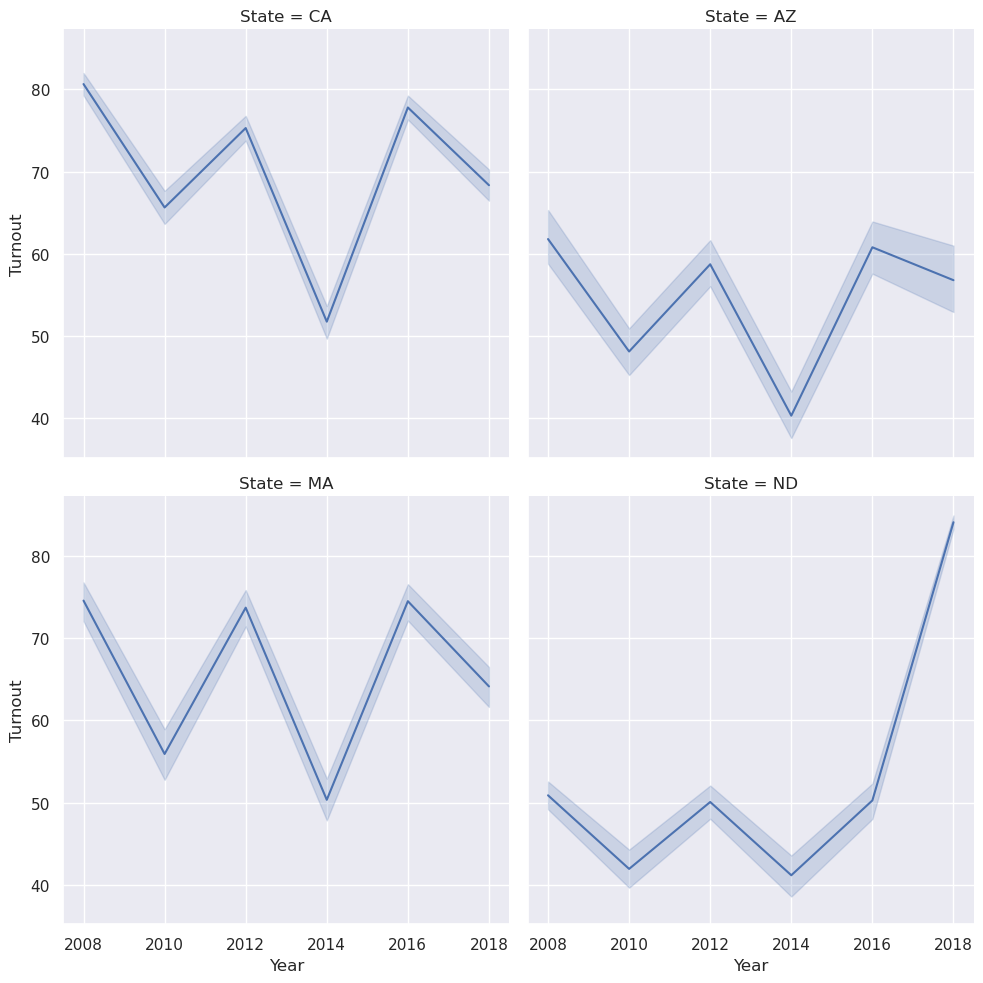

In [15]:
sns.relplot(data=turnout_df_unpivoted, kind="line", x="Year", y="Turnout", col="State", col_wrap=2)

In [16]:
#sns.relplot(data=turnout_df_unpivoted, kind="line", x="Year", y="Turnout", hue="County", col="State", col_wrap=2)

In [17]:
demographic_cols = ['Estimated_Household_Income', 'Gender', 'Age', 'Party', 'Ethnic_Group',
                    'Estimated_Home_Value', 'Education']
categorical_cols = ['Estimated_Household_Income', 'Gender', 'Party', 'Ethnic_Group', 'Education']
numeric_cols = ['Age', 'Estimated_Home_Value']

In [18]:
county_num_registered_df = df_clean.groupby('State', 'County')\
    .count()\
    .withColumnRenamed('count', 'Registered_Voters')

In [19]:
#county_num_registered_df.show(5)

In [20]:
county_num_registered_pd = county_num_registered_df.toPandas()

In [21]:
#county_num_registered_pd

In [22]:
# Create one column for each demographic variable, another column for the levels of the variable,
# and another column for how many observations at that level for each variable
temp_dfs = []
for col in categorical_cols:
    temp_df = df_clean.groupby('State', 'County', col)\
            .count()\
            .withColumn("Variable", F.lit(col))\
            .withColumnRenamed(col, 'Variable_Level')
    temp_dfs.append(temp_df)
categorical_cols_df = temp_dfs[0]
for i in range(1, len(temp_dfs)):
    categorical_cols_df = categorical_cols_df.unionByName(temp_dfs[i])

In [23]:
categorical_cols_pd = categorical_cols_df.toPandas()

In [24]:
#categorical_cols_pd

In [25]:
home_values = categorical_cols_pd.loc[categorical_cols_pd['Variable'] == 'Estimated_Household_Income']['Variable_Level'].unique()
home_value_order = [h for h in home_values if h]
home_value_order.sort(key = lambda x: int(re.findall(r'\d+', x)[0]))

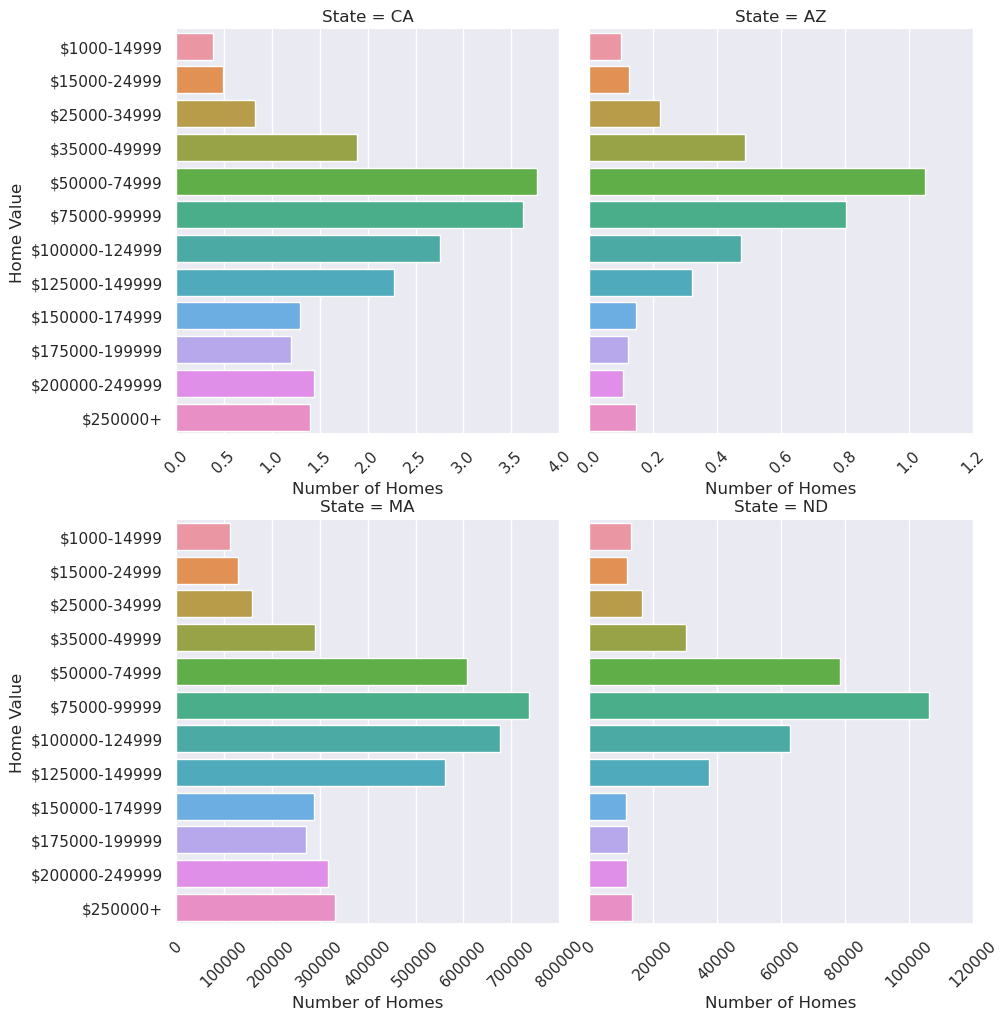

In [26]:
temp_df = categorical_cols_pd.loc[categorical_cols_pd['Variable'] == 'Estimated_Household_Income']
sns.catplot(data=temp_df, kind='bar', y='Variable_Level', x='count', estimator=sum, col='State', col_wrap=2,
            order=home_value_order, ci=None, sharex=False)\
    .set(ylabel='Home Value', xlabel='Number of Homes')\
    .set_xticklabels(rotation=45)

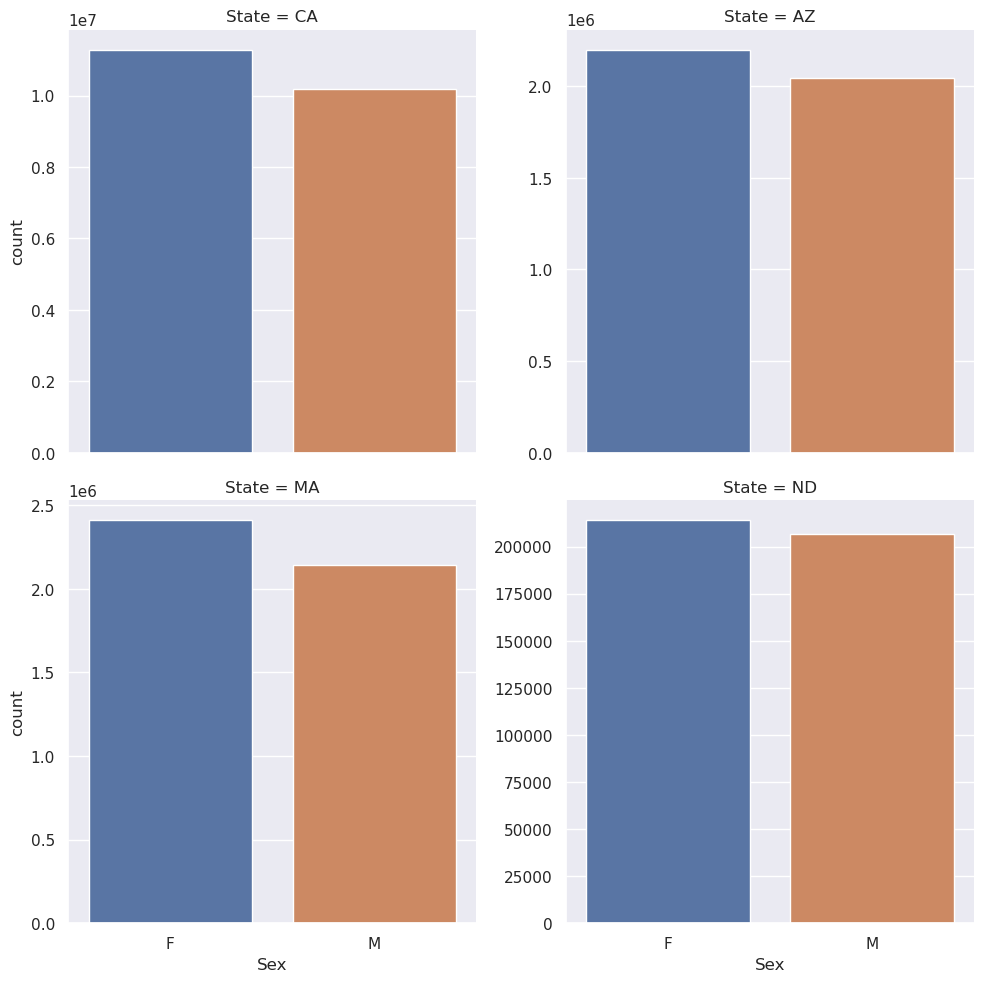

In [27]:
temp_df = categorical_cols_pd.loc[categorical_cols_pd['Variable'] == 'Gender']
sns.catplot(data=temp_df, x = 'Variable_Level', y='count', estimator=sum, kind='bar', col='State',
           col_wrap=2, sharey=False, ci=None)\
    .set(xlabel='Sex')

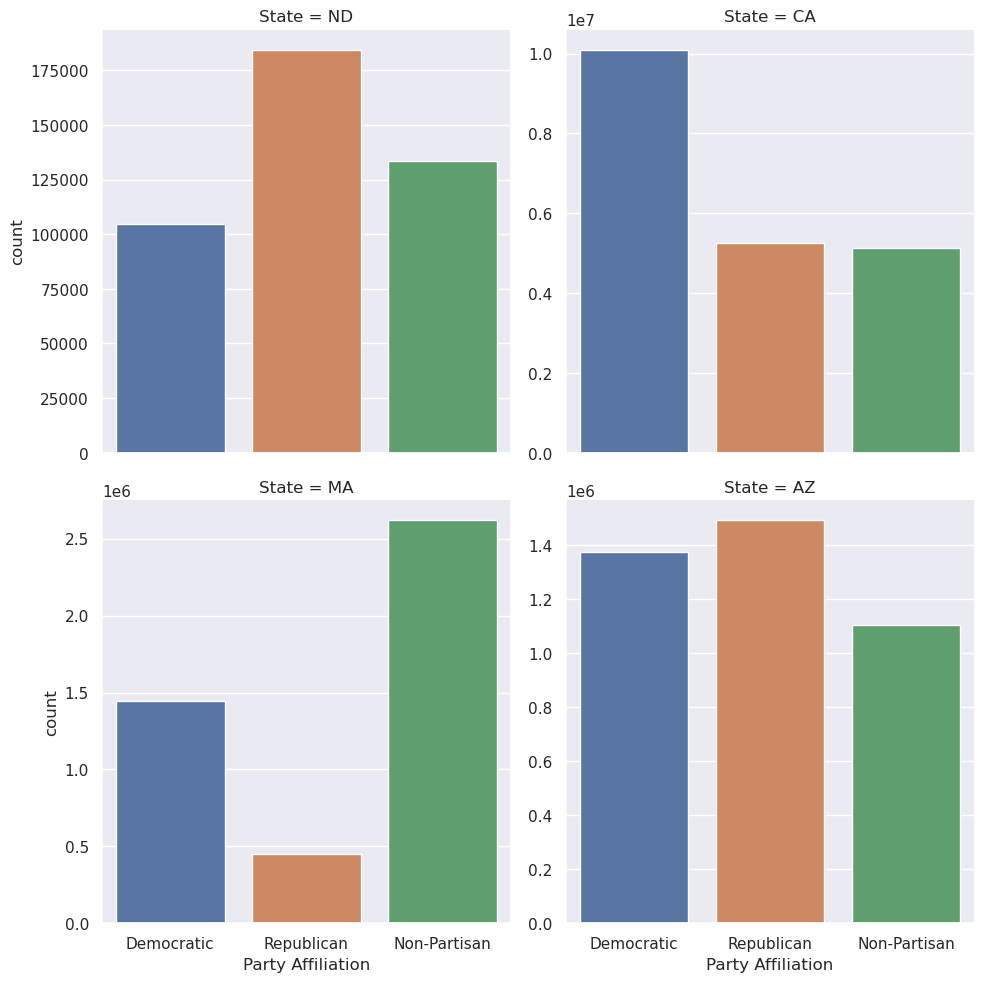

In [28]:
temp_df = categorical_cols_pd.loc[categorical_cols_pd['Variable'] == 'Party']
temp_df = temp_df.loc[temp_df['Variable_Level'].isin(['Republican', 'Democratic', 'Non-Partisan'])]
sns.catplot(data=temp_df, x = 'Variable_Level', y='count', estimator=sum, kind='bar', col='State',
           col_wrap=2, sharey=False, ci=None)\
    .set(xlabel='Party Affiliation')

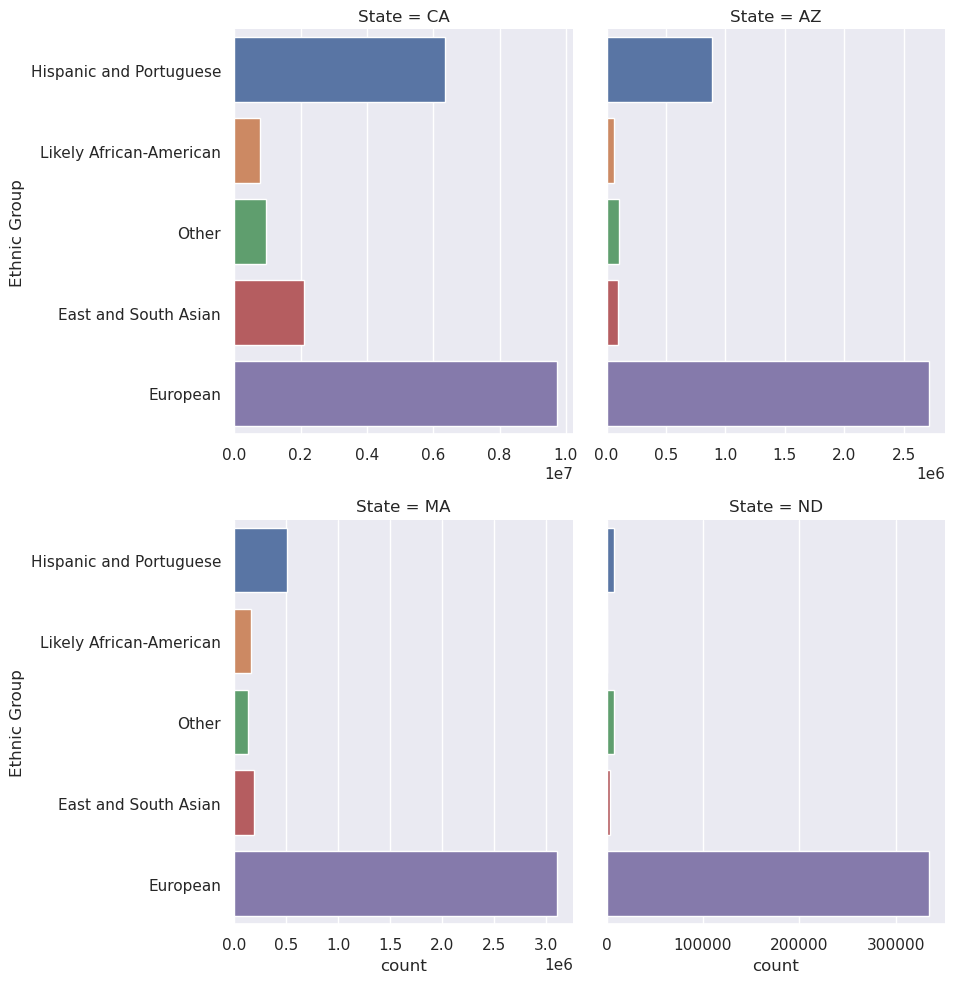

In [29]:
temp_df = categorical_cols_pd.loc[categorical_cols_pd['Variable'] == 'Ethnic_Group']
sns.catplot(data=temp_df, y = 'Variable_Level', x ='count', estimator=sum, kind='bar', col='State',
           col_wrap=2, sharex=False, ci=None)\
    .set(ylabel='Ethnic Group')

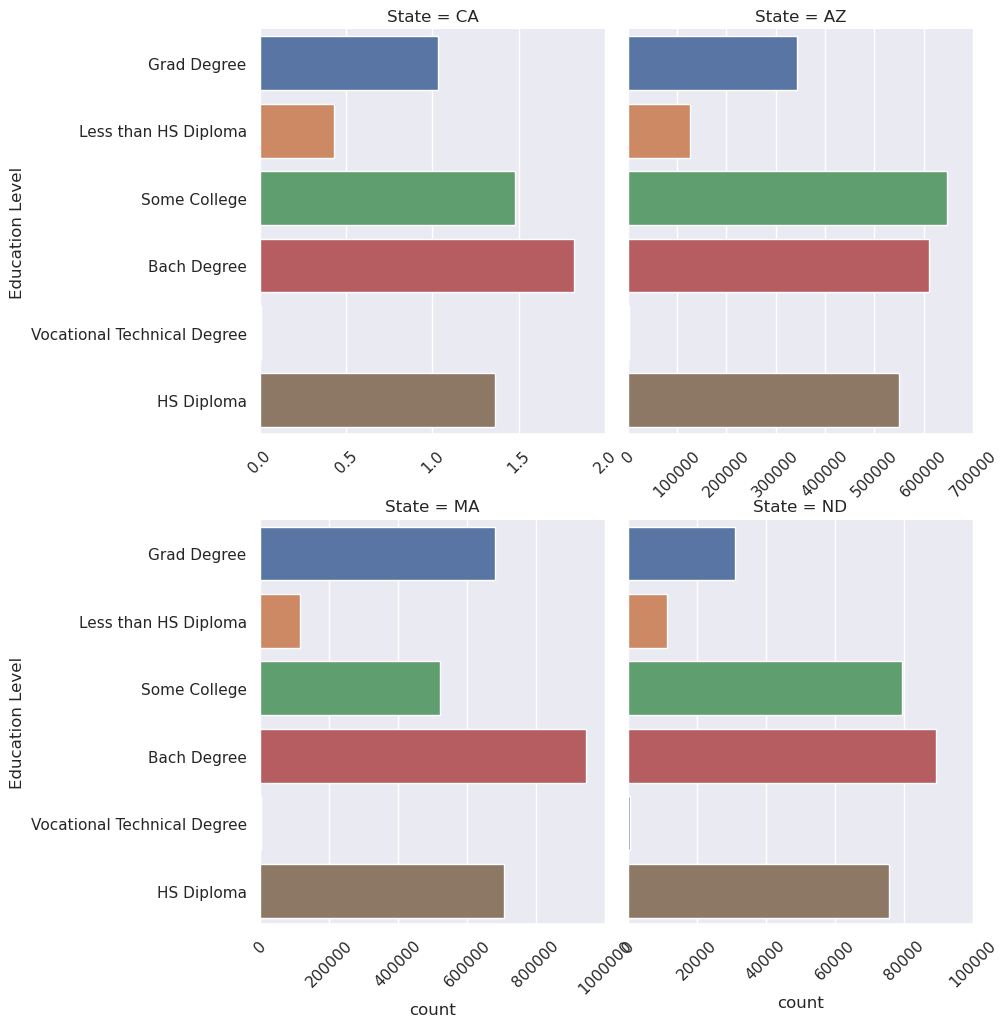

In [30]:
temp_df = categorical_cols_pd.loc[categorical_cols_pd['Variable'] == 'Education']
sns.catplot(data=temp_df, y = 'Variable_Level', x ='count', estimator=sum, kind='bar', col='State',
           col_wrap=2, sharex=False, ci=None)\
    .set(ylabel='Education Level')\
    .set_xticklabels(rotation=45)

In [31]:
numeric_cols_pd = df_clean.select('State', 'County', 'Age', 'Estimated_Home_Value')\
    .dropna()\
    .sample(fraction=.1, seed=42)\
    .toPandas()

<AxesSubplot:xlabel='Age', ylabel='Density'>

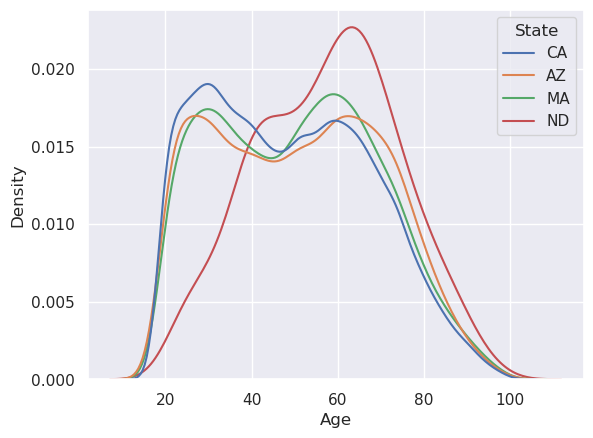

In [32]:
sns.kdeplot(data=numeric_cols_pd, x='Age', hue='State', common_norm=False, bw_adjust=2)

[Text(0.5, 0, 'Estimated Home Value')]

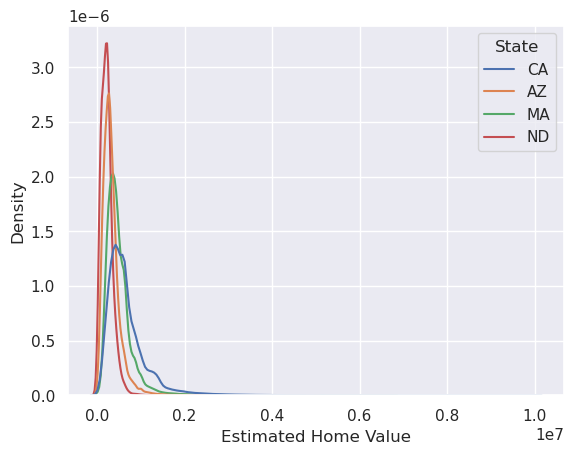

In [33]:
sns.kdeplot(data=numeric_cols_pd, x='Estimated_Home_Value', hue='State', common_norm=False, bw_adjust=2)\
    .set(xlabel='Estimated Home Value')

In [43]:
categorical_cols_no_null_pd = categorical_cols_pd[~categorical_cols_pd['Variable_Level'].isnull()].copy()
categorical_cols_no_null_pd['Proportion'] = categorical_cols_no_null_pd['count'] /\
    categorical_cols_no_null_pd.groupby(['State', 'County', 'Variable'])['count'].transform('sum')
categorical_cols_no_null_pd = categorical_cols_no_null_pd.loc[~(categorical_cols_no_null_pd['Variable'] == 'Party') \
                                                              | categorical_cols_no_null_pd['Variable_Level'].isin(['Republican', 'Democratic', 'Non-Partisan'])]

In [44]:
categorical_cols_no_null_pd

,State,County,Variable_Level,count,Variable,Proportion
1,CA,VENTURA,$25000-34999,11256,Estimated_Household_Income,0.022726
2,CA,FRESNO,$125000-149999,39738,Estimated_Household_Income,0.080878
3,CA,RIVERSIDE,$1000-14999,21545,Estimated_Household_Income,0.017276
4,CA,LOS ANGELES,$1000-14999,112505,Estimated_Household_Income,0.020454
5,CA,FRESNO,$50000-74999,114795,Estimated_Household_Income,0.233639
...,...,...,...,...,...,...
5123,ND,SHERIDAN,Grad Degree,24,Education,0.035556
5124,ND,TOWNER,Less than HS Diploma,51,Education,0.050595
5125,ND,STUTSMAN,Less than HS Diploma,463,Education,0.053850
5126,ND,STUTSMAN,Bach Degree,2714,Education,0.315655


In [45]:
categorical_cols_no_null_pd.pivot_table(index=['State', 'County'], columns='Variable_Level', values='Proportion').columns

Index(['$1000-14999', '$100000-124999', '$125000-149999', '$15000-24999',
       '$150000-174999', '$175000-199999', '$200000-249999', '$25000-34999',
       '$250000+', '$35000-49999', '$50000-74999', '$75000-99999',
       'Bach Degree', 'Democratic', 'East and South Asian', 'European', 'F',
       'Grad Degree', 'HS Diploma', 'Hispanic and Portuguese',
       'Less than HS Diploma', 'Likely African-American', 'M', 'Non-Partisan',
       'Other', 'Republican', 'Some College', 'Vocational Technical Degree'],
      dtype='object', name='Variable_Level')

In [39]:
categorical_cols_no_null_pd.columns

Index(['State', 'County', 'Variable_Level', 'count', 'Variable', 'Proportion'], dtype='object')

In [37]:
numeric_col_avgs_df = df_clean.select('State', 'County', 'Age', 'Estimated_Home_Value')\
    .groupby('State', 'County')\
    .avg()\
    .withColumnRenamed('avg(Age)', 'Average_Age')\
    .withColumnRenamed('avg(Estimated_Home_Value)', 'Average_Estimated_Home_Value')

In [38]:
#numeric_col_avgs_df.show(5)